In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

# load the model
model = models.resnet50(pretrained=True)
print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
counter = 0 
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [3]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

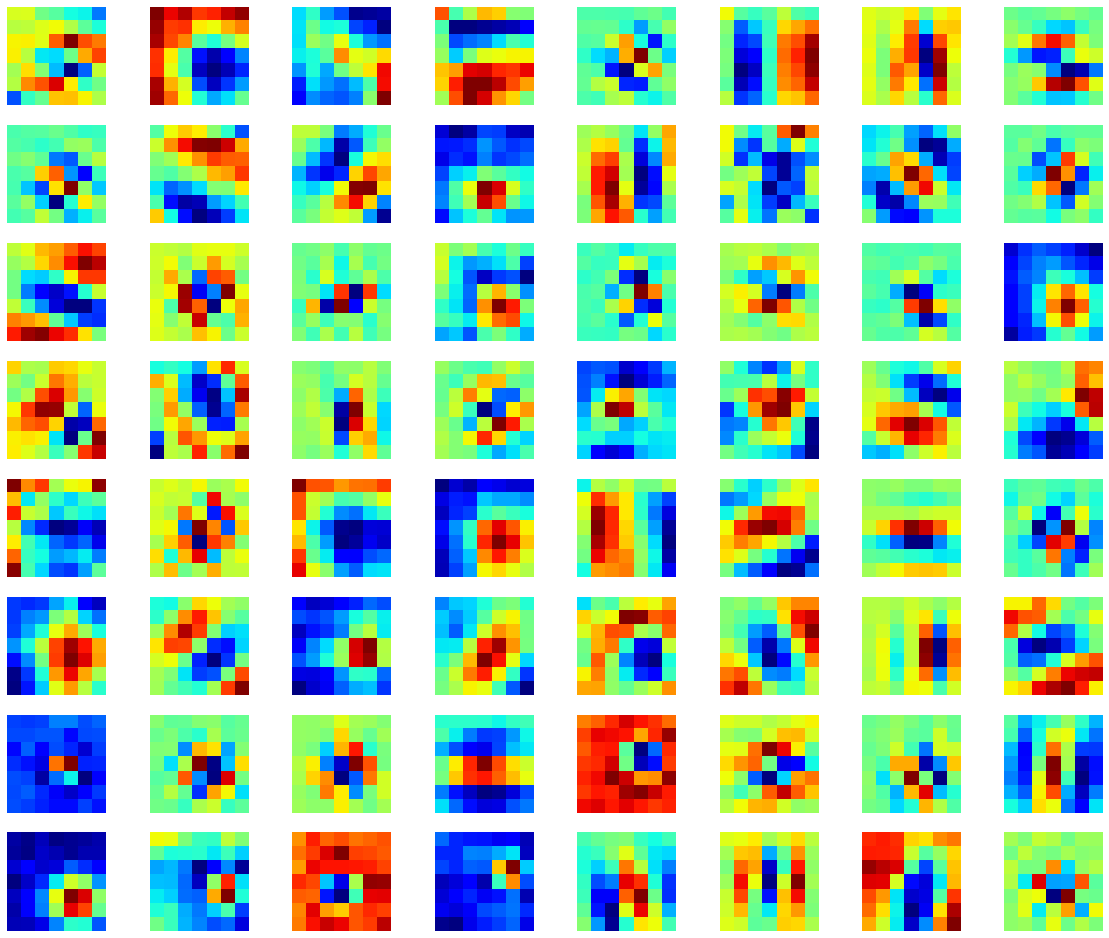

In [4]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='jet')
    plt.axis('off')
#     plt.savefig('../outputs/filter.png')
plt.show()

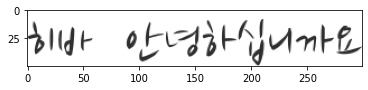

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [6]:
# read and visualize an image
img = cv.imread("./1. 데이터 관련 test/1.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [7]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([64, 256, 256])
Saving layer 0 feature maps...
torch.Size([64, 256, 256])
Saving layer 1 feature maps...
torch.Size([64, 256, 256])


KeyboardInterrupt: 

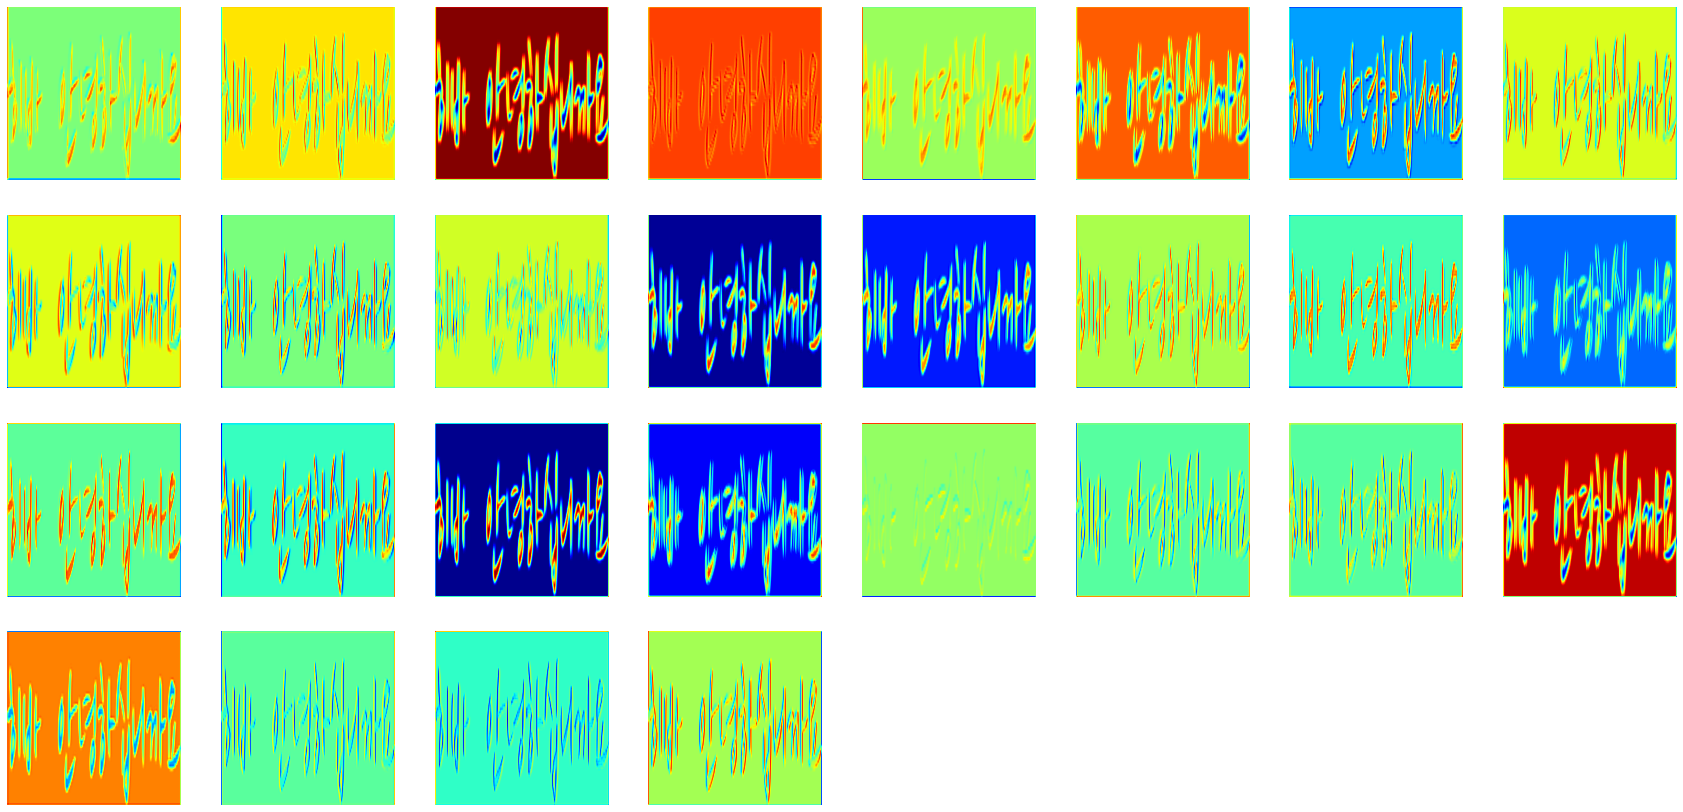

In [8]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='jet')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./layer_{num_layer}.png")
    # plt.show()
    plt.close()

In [9]:
conv_layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128,